In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

In [3]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interact, fixed


# Data
# from transat.data import HYPOTHETICAL_SUBMISSION_DATE
from transat.data.load import download_historical, load_historical
from transat.data.split import split_historical
from transat.data.transform import preprocess_historical_basic, dataframe_to_array

# Metric
from transat.metric import mae

# Scenario/Simulation
from transat.data.scenario import generate_scenario

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-09-30")

In [37]:
download_historical()
df = load_historical()

In [38]:
df = preprocess_historical_basic(df, norm_by_pop=False)
# df = preprocess_historical_basic(df)
print(df.columns)

Index(['CountryName', 'RegionName', 'GeoID', 'Date', 'NewCases',
       'NewCasesSmoothed7Days', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings'],
      dtype='object')


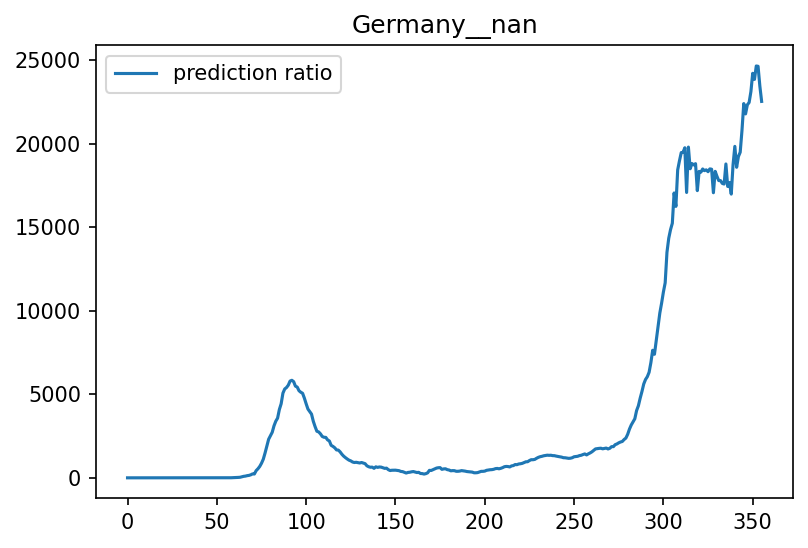

In [39]:
plt.figure()
geo_id = "Germany__nan"

plt.title(geo_id)

y = df[df.GeoID == geo_id].NewCasesSmoothed7Days.tolist()

plt.plot(y, label="prediction ratio")

plt.legend()
plt.show()

In [40]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-09-30


In [41]:
nb_lookback_days = 21
nb_lookahead_days = 1
sequence_format = False
neg_npis = False
CASES_COL = ["NewCasesSmoothed7Days"]

(X_train, y_train), (X_cols, y_col) = dataframe_to_array(df_train, nb_lookback_days=nb_lookback_days, 
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis, cases_col=CASES_COL)
(X_test, y_test), _ = dataframe_to_array(df_test, nb_lookback_days=nb_lookback_days,
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis, cases_col=CASES_COL)

print("X_train shape: ", np.shape(X_train))
print("y_train shape: ", np.shape(y_train))
print()
print("X_test  shape: ", np.shape(X_test))
print("y_test  shape: ", np.shape(y_test))

X_train shape:  (59487, 273)
y_train shape:  (59487,)

X_test  shape:  (13983, 273)
y_test  shape:  (13983,)


In [1]:
import xgboost as xgb

param_dist = {'objective':'reg:pseudohubererror', 'n_estimators':100, 'max_depth': 4}

model = xgb.XGBModel(**param_dist)

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae',
        verbose=True)

evals_result = model.evals_result()

NameError: name 'X_train' is not defined

In [43]:
evals_result

{'validation_0': OrderedDict([('mae',
               [473.796326,
                334.129852,
                237.479477,
                167.741348,
                119.629593,
                86.648224,
                63.120686,
                47.363861,
                37.064034,
                30.736101])]),
 'validation_1': OrderedDict([('mae',
               [2301.792969,
                1709.180908,
                1294.503174,
                1005.802734,
                798.902283,
                658.094788,
                562.62793,
                500.874756,
                466.305511,
                443.62207])])}

In [53]:
# Evaluate model
train_preds = model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('Train MAE:', mae(train_preds, y_train))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases

print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

Train MAE: 16.96563600639936
Test MAE: 412.93670383604183


In [54]:
def simulate_scenario(model, X_scenario, y_scenario, seq=False):
    # Simulate scenario

    X_sim = X_scenario.copy()
    X_sim_cases = X_sim[:,:,:1]
    X_sim_npis = X_sim[:,:,1:]
    y_sim = np.zeros(np.shape(y_scenario))

    nb_lookback_days = X_sim.shape[1]
    
    y_saved = None
    for d in range(y_sim.shape[1]):
        
        if seq:
            y = model.predict(X_sim)
        else:
            y = model.predict(X_sim.reshape(1,-1))
        y_sim[0,d,0] = max(y[0], 0)

        # Assuming constant NPIs here
        X_sim_npis = np.concatenate([X_sim_npis[:,1:], X_sim_npis[:,-1:]], axis=1)
        X_sim_cases = np.concatenate([X_sim_cases[:,1:], y.reshape(-1, 1, 1)], axis=1)

        X_sim =  np.concatenate([X_sim_cases, X_sim_npis], axis=-1)
        X_sim = np.array(X_sim)
    
    return y_sim

In [55]:
from transat.data.load import load_population

df_pop = load_population()

geoid_to_pop = {geoid:pop for geoid,pop in zip(df_pop.GeoID, df_pop.Population)}

def viz_scenario(geo_id, X_scenario, y_scenario, y_sim):
    
    mae_error = mae(y_scenario, y_sim)

    plt.figure()
    plt.title(geo_id)

    plot_input_x = np.arange(X_scenario.shape[1])
    plot_input_y = X_scenario[:,:,:1].reshape(-1)

    plt.plot(plot_input_x, plot_input_y, label="Input Scenario")

    plot_output_x = np.arange(y_scenario.shape[1])+X_scenario.shape[1]
    plot_output_x = np.concatenate([plot_input_x[-1:], plot_output_x])
    plot_output_y = np.concatenate([plot_input_y[-1:], y_scenario.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Scenario")


    plot_output_y = np.concatenate([plot_input_y[-1:], y_sim.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Simulation")
    
#     plot_output_y = np.concatenate([plot_input_y[-1:], y_saved.reshape(-1)])
#     plt.plot(plot_output_x[:31], plot_output_y, label="Output Simulation 12")

    plt.ylabel("New Cases")
    plt.xlabel("Days")
    ax = plt.gca()
    plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)
#     plt.yscale("log")
    plt.legend()
    plt.show()

In [56]:
def interactive_scenario(geo_id, model, seq=True):
    nb_future_days=30

    X_scenario , y_scenario = generate_scenario(df_train, df_test, geo_id, nb_lookback_days=nb_lookback_days,
        nb_future_days=nb_future_days, sequence_format=True, cases_col=CASES_COL)
    y_sim = simulate_scenario(model, X_scenario, y_scenario, seq=seq)
    
    viz_scenario(geo_id, X_scenario, y_scenario, y_sim)
    
geo_ids = sorted(df.GeoID.unique())

w_geo_id = widgets.Dropdown(
    options=geo_ids,
    value='France__nan',
    description='GeoID:',
    disabled=False
)

interact(interactive_scenario, geo_id=w_geo_id, model=fixed(model), seq=fixed(False))

interactive(children=(Dropdown(description='GeoID:', index=60, options=('Afghanistan__nan', 'Albania__nan', 'A…

<function __main__.interactive_scenario(geo_id, model, seq=True)>